#WORKSHOP_001 - Python Data Engineer
###Xilena A. Rojas Salazar

###Step 1.- Import modules and create the conection to the DB

In [52]:
#  ###Before import modules, if you didn´t have them, install:###
# !pip install sqlalchemy
# !pip install pandas
# !pip install mysqlclient
from sqlalchemy import create_engine as ce
from sqlalchemy import Column, String, Integer, Date, func
from sqlalchemy.orm import sessionmaker, declarative_base
import pandas as pd
import MySQLdb
import csv
import json


**NOTE:  **
To establish the connection to the database, it´s necessary to have a file named "config_db.json" containing your database credentials in json format. This file should include the following key-value pairs: "localhost" for the server address, "user" for the username, "password" for the password, and "database" for the specific database you intend to access. Each key should be assigned its corresponding credential value.

In [17]:
with open('config_db.json') as config_json:
    config = json.load(config_json)

mysql_engine= ce(f"mysql://{config['user']}:{config['password']}@{config['host']}/{config['database']}")

###Step 2.- Create table

**NOTE:  **
About "Base": Classes that inherit from Base become models that represent tables, but are primarily used to define the database structure, not to directly interact with data. That´s why I´m using it to create the table in my db.

In [24]:
Base= declarative_base()


class Table(Base):
    __tablename__ = 'candidates'
    id = Column('id', Integer, primary_key=True, autoincrement= True)
    first_name = Column('first_name', String(20))
    last_name  = Column ('last_name',String (20))
    email = Column('email',String(50))
    application_date = Column('application_date', Date)
    country = Column('country', String(60))
    yoe = Column('yoe', Integer) #This means Years Of Experience
    seniority = Column('seniority', String(15))
    technology = Column('technology', String(50))
    code_challenge_Score = Column('code_challenge_Score', Integer)
    technical_intrvw_score = Column('technical_intrvw_score', Integer)

Base.metadata.create_all(mysql_engine)

**NOTE:  **
You can check the db to see if your table was created correctly.
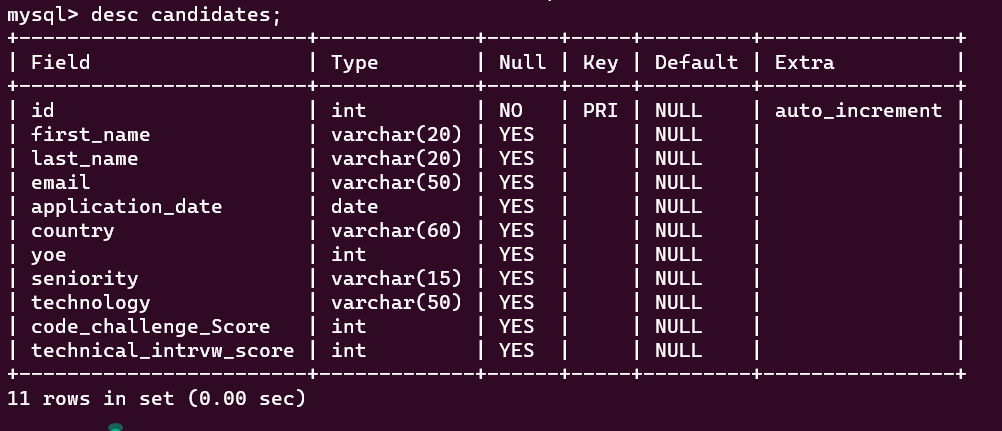

###Step 3.- Load the data to the db from a csv file

**NOTE:  **
About "Session" and "session": This creates a session, just as the names tell us, that help to interact with the data (insert, delete, modify). 

In [ ]:
Session = sessionmaker(bind=mysql_engine)
session = Session()

file = "candidates.csv"
data = pd.read_csv(file, sep=";")
#print(data)

count = session.query(func.count()).select_from(Table).scalar()
data_in_db = count > 0
# print(count)
# print(data_in_db)

if not data_in_db:
    for _, i in data.iterrows():
        record = Table(
            first_name=i['first_name'],
            last_name=i['last_name'],
            email=i['email'],
            application_date=i['application_date'],
            country=i['country'],
            yoe=i['yoe'],
            seniority=i['seniority'],
            technology=i['technology'],
            code_challenge_Score=i['code_challenge_Score'],
            technical_intrvw_score=i['technical_intrvw_score']
        )
        session.add(record)


    session.commit()
session.close()



###REFERENCES
* https://docs.sqlalchemy.org/en/20/orm/quickstart.html 
* https://www.andrewvillazon.com/move-data-to-db-with-sqlalchemy/
* https://towardsdatascience.com/sqlalchemy-python-tutorial-79a577141a91
* https://auth0.com/blog/sqlalchemy-orm-tutorial-for-python-developers/
* https://stackoverflow.com/questions/43453420/import-csv-to-database-using-sqlalchemy
* https://stackoverflow.com/questions/44511046/sqlalchemy-prevent-duplicate-rows
* https://stackoverflow.com/questions/10822635/get-the-number-of-rows-in-table-using-sqlalchemy